In [47]:
# Scrape https://cdn.kadastr.live/tiles/maps/kadastr/{z}/{x}/{y}.pbf tiles from this tile server
# Choose zoom level 13, and get only those that are within the bounds of the city o

In [48]:
import folium
import json
import requests
import ee
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, gamma, f, chi2
import IPython.display as disp
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [49]:
city_name = 'Sviatohirsk'
gdf_boundaries = gpd.read_file(f"./data/{city_name}_boundary.geojson")

In [50]:
# Get rectangular polygon of the boundaries of the city
city_bbox = gdf_boundaries.geometry.envelope
city_bbox = city_bbox.to_crs(epsg=4326)

# Plot both the city boundary and the city in folium, with center of the map being the centroid of the city
m = folium.Map(location=[city_bbox.centroid.y, city_bbox.centroid.x], zoom_start=14)
folium.GeoJson(city_bbox).add_to(m)
folium.GeoJson(gdf_boundaries).add_to(m)
m


/var/folders/yq/0zz796hs77l_70crv1b3x6z80000gn/T/ipykernel_21519/3228126238.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[city_bbox.centroid.y, city_bbox.centroid.x], zoom_start=14)
/Users/hermanmitish/private/satellite-analysis/.conda/lib/python3.11/site-packages/folium/utilities.py:94: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(coord)
/Users/hermanmitish/private/satellite-analysis/.conda/lib/python3.11/site-packages/folium/utilities.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  if math.isnan(float(coord)):
/Users/hermanmitish/private/satellite-analysis/.conda/lib/python3.11/site-packages/folium/utilities

In [51]:
city_bbox.bounds.iloc[0]

minx    37.534657
miny    49.025081
maxx    37.588276
maxy    49.055983
Name: 0, dtype: float64

In [52]:
import os
# Make ./data directory if it doesn't exist
if not os.path.exists('./data/tiles'):
    os.makedirs('./data/tiles')

In [59]:
import subprocess
import requests
import math
from shapely.geometry import Polygon

def deg2num(lat_deg, lon_deg, zoom):
    lat_rad = math.radians(lat_deg)
    n = 2.0 ** zoom
    xtile = int((lon_deg + 180.0) / 360.0 * n)
    ytile = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
    return (xtile, ytile)

def get_tiles_within_bbox(city_bbox, zoom):
    min_lon, min_lat, max_lon, max_lat = city_bbox.bounds.iloc[0]
    print(min_lat, min_lon, max_lat, max_lon)
    min_x, min_y = deg2num(max_lat, min_lon, zoom)
    max_x, max_y = deg2num(min_lat, max_lon, zoom)
    
    tiles = []
    for x in range(min_x, max_x + 1):
        for y in range(min_y, max_y + 1):
            tiles.append((zoom, x, y))
    return tiles

zoom_level = 13
tiles = get_tiles_within_bbox(city_bbox, zoom_level)

geojson_chunks = []
for z, x, y in tiles:
    url = f"https://cdn.kadastr.live/tiles/maps/kadastr/{z}/{x}/{y}.pbf" # You could put any tiles url in here, in the same format as in QGIS
    r = requests.get(url)
    folder = f"./data/tiles/{city_name}/{z}/{x}/"
    if not os.path.exists(folder):
        os.makedirs(folder)
    with open(f"{folder}{y}.pbf", 'wb') as f:
        f.write(r.content)
        try:
            # os.system(f"ogr2ogr -q -f GeoJSON {folder}{y}.geojson {folder}{y}.pbf -skipfailures")
            command = ["ogr2ogr", "-f", "GeoJSON", f"{folder}{y}.geojson", f"{folder}{y}.pbf"]
            with open(os.devnull, 'wb') as devnull:
                subprocess.run(command, stdout=devnull, stderr=devnull)
            chunk = gpd.read_file(f"{folder}{y}.geojson")
            geojson_chunks.append(chunk)
            print(f'Read tile: {z}/{x}/{y}')
        except:
            print(f'Skip tile: {z}/{x}/{y}')



49.0250815 37.5346569 49.0559826 37.588276
Read tile: 13/4950/2811
Read tile: 13/4950/2812
Read tile: 13/4951/2811
Read tile: 13/4951/2812


<Axes: >

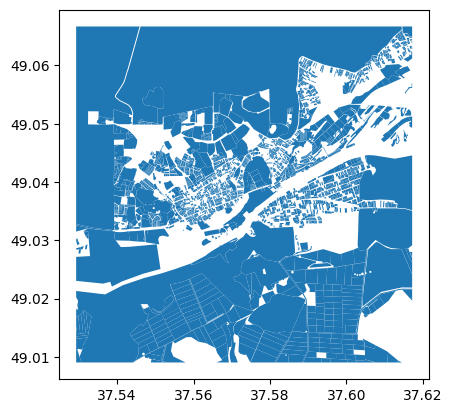

In [60]:
# Merge all the chunks into one GeoDataFrame
gdf = gpd.GeoDataFrame(pd.concat(geojson_chunks, ignore_index=True)).set_crs(crs=3857, allow_override=True)
gdf = gdf.to_crs(epsg=4326)
# merge (union) geometrical features by mvt_id property 
gdf = gdf.dissolve(by='mvt_id')
# save to ./data/{city_name}_land_ownership.geojson
gdf.to_file(f"./data/{city_name}_land_ownership_z{zoom_level}.geojson", driver='GeoJSON')
gdf.plot()

In [61]:
# merge f"{city_name}_land_ownership.geojson" with f"{city_name}_footprints_final.geojson", to set land ownership and all the props of it to each building
gdf_land_ownership = gpd.read_file(f"./data/{city_name}_land_ownership_z{zoom_level}.geojson")
gdf_footprints = gpd.read_file(f"./data/{city_name}_footprints_final.geojson")
# generate ids for each building
gdf_footprints['footprint_idx'] = range(len(gdf_footprints))

gdf_land_ownership = gdf_land_ownership.to_crs(epsg=4326)
gdf_footprints = gdf_footprints.to_crs(epsg=4326)

# Make a spatial join between the two GeoDataFrames, to assign land ownership to each building
gdf_footprints = gpd.sjoin(gdf_footprints, gdf_land_ownership, how='left', op='intersects')
gdf_footprints = gdf_footprints.drop_duplicates(subset='footprint_idx')  # Replace 'footprint_id' with your unique identifier column

gdf_footprints.to_file(f'./data/{city_name}_damage_zoning_z{zoom_level}.geojson')
gdf_footprints


/Users/hermanmitish/private/satellite-analysis/.conda/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,value,timestamp,geometry,footprint_idx,index_right,mvt_id,ownership,cadnum,purpose,category,address
0,0.0,,"POLYGON ((37.54254 49.04200, 37.54249 49.04153...",0,220.0,690266721.0,Приватна власність,1414170500:01:001:0581,07.01 Для будівництва та обслуговування об'єкт...,Землі рекреаційного призначення,"Донецька область, м.Святогірськ, вулиця Остров..."
1,0.0,,"POLYGON ((37.55587 49.03708, 37.55580 49.03707...",1,1647.0,690269648.0,Приватна власність,1414170500:01:003:0042,02.01 Для будівництва і обслуговування житлово...,Землі житлової та громадської забудови,"Донецька область, м. Святогірськ, вулиця 1 Тра..."
2,0.0,,"POLYGON ((37.55575 49.04455, 37.55631 49.04480...",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,,"POLYGON ((37.55660 49.04085, 37.55685 49.04085...",3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,,"POLYGON ((37.55786 49.05185, 37.55777 49.05186...",4,541.0,690267542.0,Приватна власність,1414170500:01:001:1039,Рекреаційного призначення,Землі рекреаційного призначення,"Донецька область, м. Святогірськ, вулиця Куйби..."
...,...,...,...,...,...,...,...,...,...,...,...
3931,0.0,,"POLYGON ((37.57369 49.04367, 37.57377 49.04372...",3931,1140.0,690269141.0,Приватна власність,1414170500:01:002:0445,"Для індивідуального житлового, гаражного і дач...",Землі житлової та громадської забудови,"Донецька область, м. Святогірськ, вулиця вул. ..."
3932,0.0,,"POLYGON ((37.57909 49.05329, 37.57909 49.05320...",3932,583.0,690267584.0,Комунальна власність,1414170500:01:001:1099,07.01 Для будівництва та обслуговування об'єкт...,Землі рекреаційного призначення,"Донецька область, м. Святогірськ, вулиця Куйби..."
3933,0.0,,"POLYGON ((37.58051 49.04159, 37.58051 49.04161...",3933,1206.0,690269207.0,Приватна власність,1414170500:01:002:0530,"Для індивідуального житлового, гаражного і дач...",Землі житлової та громадської забудови,"Донецька область, м. Святогірськ, вулиця Комсо..."
3934,0.0,,"POLYGON ((37.58259 49.04544, 37.58251 49.04536...",3934,NaN,NaN,NaN,NaN,NaN,NaN,NaN
